In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
!pip install mediapipe
import mediapipe as mp
import os
import json

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.9 MB 1.2 MB/s 


# Load Trained VAE





In [ ]:
vae_path = '/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/vae_encoder/vae_2022-07-11_16:53:53'
vae_encoder = tf.keras.models.load_model(vae_path)

vae_encoder.summary()

Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vae_encoder_input (InputLay  [(None, 68, 3)]          0         
 er)                                                             
                                                                 
 vae_flatten (Flatten)       (None, 204)               0         
                                                                 
 vae_dense_1 (Dense)         (None, 200)               41000     
                                                                 
 vae_dense_2 (Dense)         (None, 100)               20100     
                                                                 
 vae_dense_3 (Dense)         (None, 50)                5050      
                                                                 
 z_mean (Dense)              (None, 4)                 204       
                                                          

# Load MediaPipe model to get the set of mesh points

In [ ]:
mp_face_mesh = mp.solutions.face_mesh

left_eye_point = set(sum(mp_face_mesh.FACEMESH_LEFT_EYE, ()))
right_eye_point = set(sum(mp_face_mesh.FACEMESH_RIGHT_EYE, ()))
left_iris_point = set(sum(mp_face_mesh.FACEMESH_LEFT_IRIS, ()))
right_iris_point = set(sum(mp_face_mesh.FACEMESH_RIGHT_IRIS, ()))

face_oval_point = set(sum(mp_face_mesh.FACEMESH_FACE_OVAL, ()))

#keypoints = left_eye_point.union(right_eye_point).union(left_iris_point).union(right_iris_point)

keypoints = left_eye_point.union(right_eye_point).union(face_oval_point)

keypoints = sorted(list(keypoints))
irises = [469, 470, 471, 472, 474, 475, 476, 477]
face_cross = [226, 446, 9, 195]

# Load in one JSON file as an example

In [ ]:
json_path = '/content/drive/Shareddrives/URSI 2022/Eye Tracking ML/json/'
all_json_files = os.listdir(json_path)

# load one file as an example
filename = all_json_files[0]
with open(json_path + filename, 'r') as file:
    json_data = json.load(file)

# Extract the facemesh features from the video frames

In [ ]:
frames = []

for subject in json_data:
  subject_data = json_data[subject];
  
  for video in subject_data:
    for all_features in video['features']:
      frames.append([all_features[i] for i in keypoints])

# Use trained model to get latent features

In [ ]:
print(tf.shape(frames))

latent_features = vae_encoder.predict(frames)

tf.Tensor([3605   68    3], shape=(3,), dtype=int32)


In [ ]:
print(tf.shape(latent_features))

tf.Tensor([3605    4], shape=(2,), dtype=int32)


# Ridge Regression Model Using Latent Features

In [ ]:
from re import X
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import statistics
import math

def is_calibration_data(dict):
  if dict["phase"] == "calibration":
    return True
  else: return False

def is_test_data(dict):
  if dict["phase"] == "test":
    return True
  else: return False

def get_tc_data(dict):
  all_videos_data = []
  for key, value in dict.items():
    for per_video_data in value:
      all_videos_data.append(per_video_data)
  calibration_data = list(filter(is_calibration_data, all_videos_data))
  test_data = list(filter(is_test_data, all_videos_data))
  return calibration_data, test_data

def get_line(pt1, pt2):
  x1, y1 = pt1
  x2, y2 = pt2
  a = (y2 - y1) / (x2 - x1)
  b = y1 - (a * x1)
  return [a, b]

def get_intersection(l1, l2):
  a1, b1 = l1
  a2, b2 = l2
  x = (b2 - b1) / (a1 - a2)
  y = a1 * x + b1
  return [x, y]

def get_ccw_angle(vector):
  x, y = vector
  tan = y / x
  r = math.atan(tan)
  if x >= 0 and y > 0:
    pass
  elif x < 0 and y >= 0:
    r = r + math.pi
  elif x <= 0 and y < 0:
    r = r + math.pi
  elif x > 0 and y <= 0:
    r = r + 2 * math.pi
  else:
    r = 0
  return r

def face_plane(points3d):
  points2d = []
  for point3d in points3d:
    point3d.pop()
    points2d.append(point3d)
  pt1, pt2, pt3, pt4 = points2d
  xaxis = get_line(pt1, pt2)
  yaxis = get_line(pt3, pt4)
  origin = get_intersection(xaxis, yaxis)
  v = []
  for a, b in zip(pt1, pt2):
    v.append(b - a)
  rad = 2 * math.pi - get_ccw_angle(v)
  return origin, rad

def normalize(origin, points, angle):
  ox, oy = origin
  normalized_points = []
  for point in points:
    px, py, pz = point
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    nx = qx - ox
    ny = qy - oy
    normalized_points.append([nx, ny])
  return normalized_points

def split_and_flatten_data(v_list):
  predictor_data = []
  output_data = []
  normalized_irises = []
  original_irises = []
  for video in v_list:
    coor = [int(video["x"]), int(video["y"])]
    features = video["features"]
    for feature in features:
      output_data.append(coor)
      face_frame = [feature[i] for i in keypoints]
      predictor_data.append(face_frame)
      irises_data = [feature[i] for i in irises]
      original_irises.append(irises_data)
      o, r = face_plane([feature[i] for i in face_cross])
      normalized_data = normalize(o, irises_data, r)
      normalized_irises.append(normalized_data)
  return predictor_data, output_data, normalized_irises, original_irises

def split_xy(lst_of_coor):
  x = []
  y = []
  for coor in lst_of_coor:
    x.append(coor[0])
    y.append(coor[1])
  x = np.array(x)
  y = np.array(y)
  return x, y

def draw_one_subject(lst_of_coor):
  x, y = split_xy(lst_of_coor)
  plt.scatter(x, y)


In [ ]:
def process_predictor(target, iris):
  latent_feature = vae_encoder.predict(target)
  all_features = []
  for ni, lf in zip(iris, latent_feature):
    ni = np.array(ni).flatten().tolist()
    lf = list(lf)
    lf.extend(ni)
    all_features.append(lf)
  return all_features

tf.Tensor([1106   68    3], shape=(3,), dtype=int32)
tf.Tensor([1106    2], shape=(2,), dtype=int32)
tf.Tensor([1106    8    2], shape=(3,), dtype=int32)
tf.Tensor([1106   20], shape=(2,), dtype=int32)


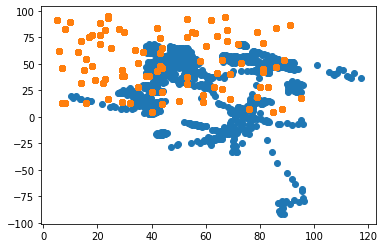

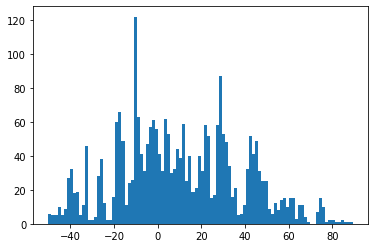

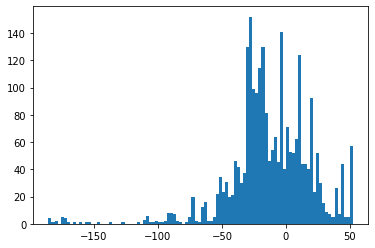

In [ ]:
c_data, t_data = get_tc_data(json_data)
c_training_data, c_target_data, c_nirises, c_irises = split_and_flatten_data(c_data)
t_predictor_data, t_output_data, t_nirises, t_irises = split_and_flatten_data(t_data)

print(tf.shape(c_training_data))
print(tf.shape(c_target_data))
print(tf.shape(c_nirises))

c_features = process_predictor(c_training_data, c_nirises)
t_features = process_predictor(t_predictor_data, t_nirises)

print(tf.shape(c_features))


ridge_model = Ridge()
ridge_model.fit(c_features, c_target_data, None)

predictions = ridge_model.predict(t_features)

draw_one_subject(predictions)
draw_one_subject(t_output_data)
plt.show()

t_x, t_y = split_xy(t_output_data)
p_x, p_y = split_xy(predictions)

x_residuals = p_x - t_x
y_residuals = p_y - t_y
plt.hist(x_residuals, bins = 100)
plt.show()
plt.hist(y_residuals, bins = 100)
plt.show()

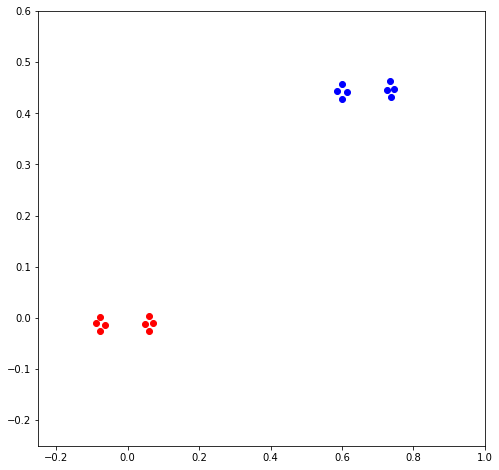

In [ ]:
from matplotlib.animation import FuncAnimation

x1 = []
y1 = []
coords1 = []
for i in range(len(t_nirises[0])):
  x1.append(t_nirises[0][i][0])
  y1.append(t_nirises[0][i][1])
  coords1.append([t_nirises[0][i][0], t_nirises[0][i][1]])
x2 = []
y2 = []
coords2 = []
for i in range(len(t_irises[0])):
  x2.append(t_irises[0][i][0])
  y2.append(t_irises[0][i][1])
  coords2.append([t_irises[0][i][0], t_irises[0][i][1]])

fig = plt.figure(figsize=(8,8))
ax = plt.axes(xlim=(-0.25,1),ylim=(-0.25,0.6))
scatter = ax.scatter(x1, y1, c='red')
scatter2 = ax.scatter(x2, y2, c='blue')
k = 0

def animate(n):
  global k
  x1 = []
  y1 = []
  coords1 = []
  normalized = t_nirises[n]
  for i in range(len(normalized)):
    x1.append(normalized[i][0])
    y1.append(normalized[i][1])
    coords1.append([normalized[i][0], normalized[i][1]])

  x2 = []
  y2 = []
  coords2 = []
  original = t_irises[n]
  for i in range(len(original)):
    x2.append(original[i][0])
    y2.append(original[i][1])
    coords2.append([original[i][0], original[i][1]])

  scatter.set_offsets(coords1)
  scatter2.set_offsets(coords2)
  k += 1
  return scatter, scatter2

anim = FuncAnimation(fig, animate, frames=(len(t_irises)), interval=60)
from IPython.display import HTML
HTML(anim.to_html5_video())